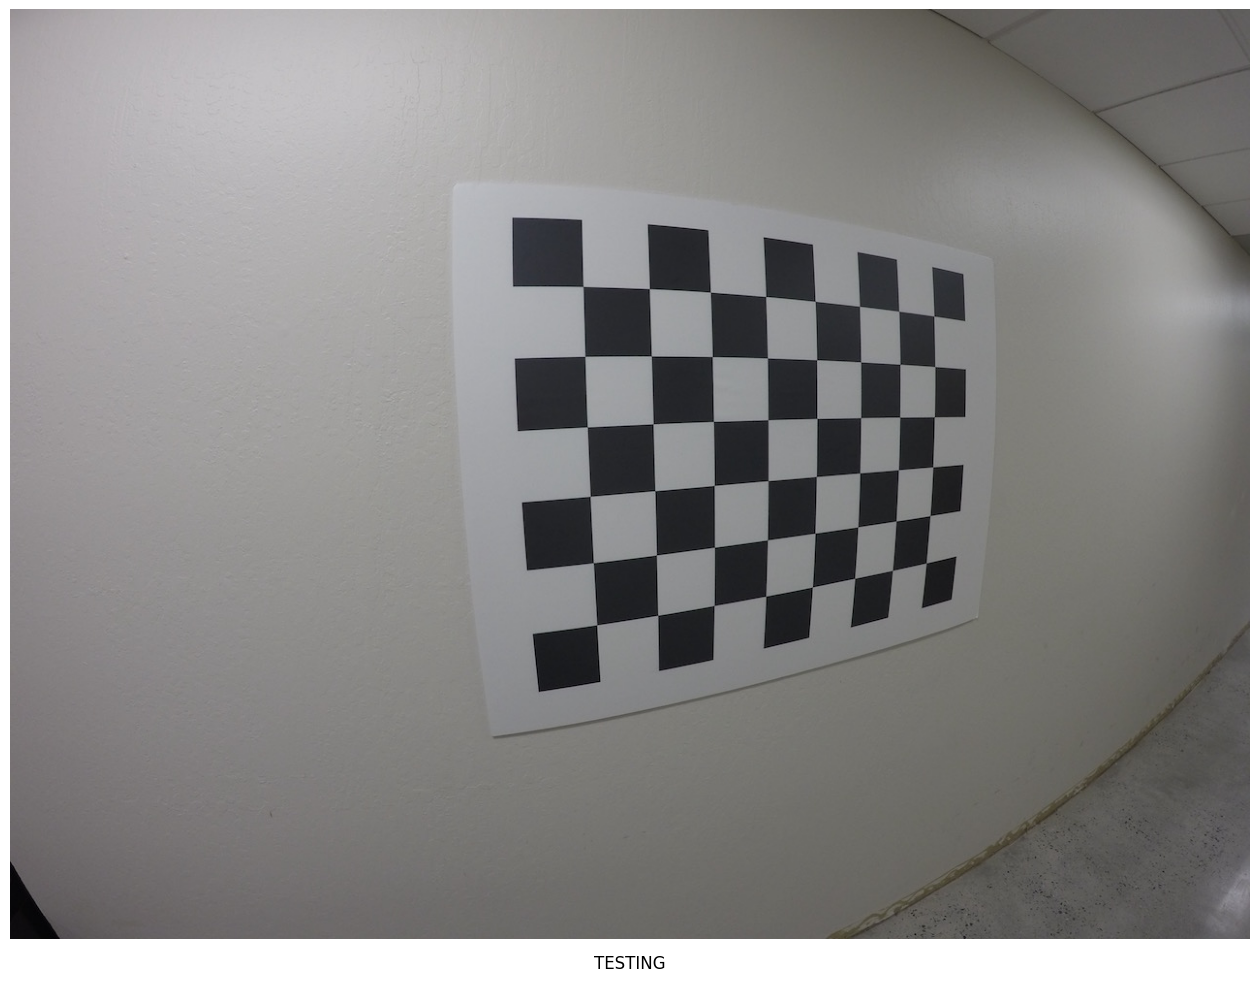

In [4]:
import sys
import ctypes
import numpy as np
from PIL import Image
from scipy import signal
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import glob
import pickle
np.set_printoptions(suppress=True, edgeitems=30, linewidth=256)


def show_img(img, caption):
    f, axarr = plt.subplots(1,1, figsize=(16,16))
    axarr.imshow(img)
    axarr.set_axis_off()
    axarr.set_title(caption, y=-.04)
    
def sRGB_to_grayscale_linear(img):
    
    # Normalize to 0.0->1.0 range
    n_img = np.array(img, dtype=np.float32) / 255.0

    # Gamma correction removal - see https://en.wikipedia.org/wiki/Grayscale
    lower_mask   = n_img <= 0.04045
    upper_mask   = n_img >  0.04045
    lower_update = n_img[:] / 12.92
    upper_update = np.power( ( (n_img[:] + 0.055) / 1.055), 2.4 )
    
    l_rgb = (lower_mask * lower_update) + (upper_mask * upper_update)  
    
    # Map to RGB
    gray = l_rgb[:,:,0] * 0.2126 + l_rgb[:,:,1] * 0.7152 + l_rgb[:,:,2] * 0.0722     
    return gray
    
img_test = np.asarray(Image.open('./calibration/GOPR0043.jpg'))
show_img(img_test, 'TESTING')

In [5]:
#############################################################################################################
# STARTER code and GO-PRO data derived from:
#  https://github.com/tejakummarikuntla/camera-calibration-opencv/blob/master/camera_calibration.ipynb
#############################################################################################################

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./calibration/*.jpg')
print(images)

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv.findChessboardCorners(gray, (8,6), None)

    # If found, add object points, image points
    if ret == True:
        corners = np.array(corners)
        corners = corners.reshape(corners.shape[0], corners.shape[-1])
        
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        # cv.drawChessboardCorners(img, (8,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        # cv.imshow('img', img)
        # cv.waitKey(500)
    print('Done with ' + str(idx))

cv.destroyAllWindows()


['./calibration/GOPR0050.jpg', './calibration/GOPR0035.jpg', './calibration/GOPR0042.jpg', './calibration/test_image.jpg', './calibration/GOPR0045.jpg', './calibration/GOPR0043.jpg', './calibration/GOPR0038.jpg', './calibration/GOPR0047.jpg', './calibration/GOPR0036.jpg', './calibration/GOPR0070.jpg', './calibration/GOPR0046.jpg', './calibration/GOPR0052.jpg', './calibration/GOPR0034.jpg', './calibration/GOPR0040.jpg', './calibration/GOPR0068.jpg', './calibration/GOPR0057.jpg', './calibration/GOPR0049.jpg', './calibration/GOPR0067.jpg', './calibration/GOPR0066.jpg', './calibration/test_undist.jpg', './calibration/GOPR0037.jpg', './calibration/GOPR0033.jpg', './calibration/GOPR0055.jpg', './calibration/GOPR0048.jpg', './calibration/GOPR0061.jpg', './calibration/GOPR0044.jpg', './calibration/GOPR0032.jpg', './calibration/GOPR0054.jpg', './calibration/GOPR0058.jpg', './calibration/GOPR0060.jpg', './calibration/GOPR0053.jpg', './calibration/GOPR0064.jpg', './calibration/GOPR0059.jpg', './c

In [39]:
# DEBUG...
# path = 'C:\\Users\\dane\\Desktop\\CameraCalibration-master\\sample_data\\'
# path_obj = path + 'model.txt'

# # Write OBJ to file
# f = open(path_obj, 'w')
# for row in objpoints[0]:
#     line = str(row[0]) + ' ' + str(row[1]) + '\n'
#     f.write(line)
# f.close()

# for i, img_point_set in enumerate(imgpoints):
#     path_img = path + str(i).zfill(3) + '.txt'

#     f = open(path_img, 'w')
#     for row in imgpoints[i]:
#         line = str(row[0]) + ' ' + str(row[1]) + '\n'
#         f.write(line)
#     f.close()
    

Reference Camera_Intrinsics:
 [[560.26831365   0.         651.26205498]
 [  0.         561.31870941 499.05498086]
 [  0.           0.           1.        ]]
Reference Camera_Distortion:
 [[-0.23287639  0.06167888 -0.00001402  0.00003819 -0.00754075]]


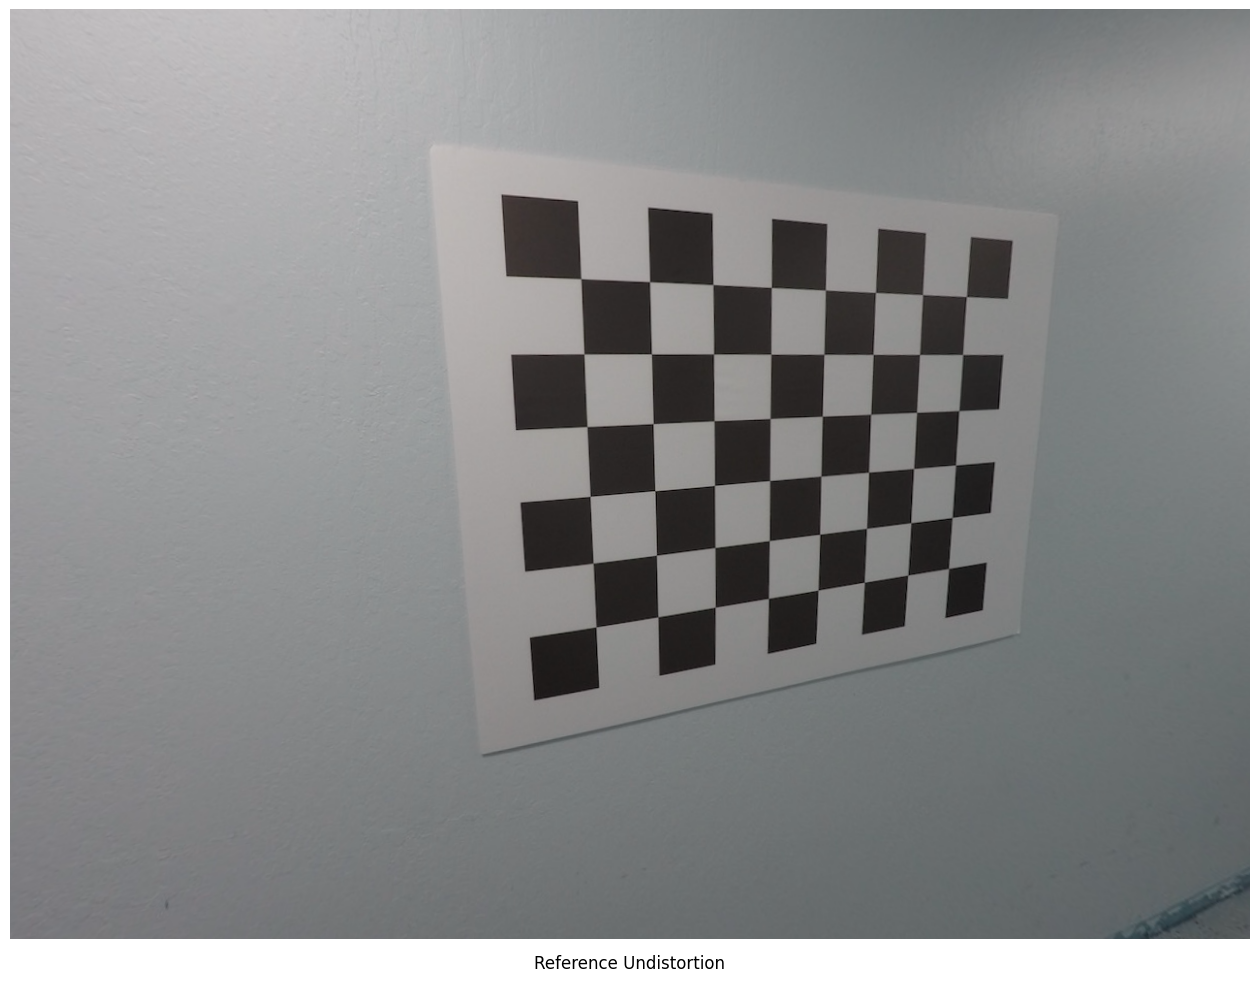

In [6]:
# OPENCV way
img = cv.imread('./calibration/GOPR0043.jpg')
h, w, z = img.shape[:]
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, (w,h), None, None)

print('Reference Camera_Intrinsics:\n', mtx)
print('Reference Camera_Distortion:\n', dist)
#newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

small_scale = 1
dst = cv.undistort(img, mtx, dist, None, mtx)
dst_small = cv.resize(dst, ( int(dst.shape[1]*small_scale), int(dst.shape[0]*small_scale)) )
show_img(dst_small, 'Reference Undistortion')
# cv.imshow('undist', dst_small)
# cv.waitKey()

In [7]:
_all_hs = []
_all_hs_opt = []

def _rotation_matrix_to_rodrigues(rot_mat):
    assert (len(rot_mat.shape) == 2 and rot_mat.shape[0] == 3 and rot_mat.shape[1] == 3), 'Rotation matrix must be a 3x3 matrix'

    trace = rot_mat[0][0] + rot_mat[1][1] + rot_mat[2][2]

    a_cos_input = (trace - 1.0) / 2.0
    a_cos_input = np.max( (-1.0, a_cos_input) )
    a_cos_input = np.min( (1.0, a_cos_input) )

    theta = np.arccos( a_cos_input )

    if (theta == 0.0):
        return np.array([0.0, 0.0, 0.0])

    two_sine_theta = 2.0 * np.sin(theta)
    ax = (rot_mat[2][1] - rot_mat[1][2]) / two_sine_theta
    ay = (rot_mat[0][2] - rot_mat[2][0]) / two_sine_theta
    az = (rot_mat[1][0] - rot_mat[0][1]) / two_sine_theta

    rodrigues_vec = np.array([ax, ay, az])

    # Make the length of the vector the angle in radians
    rodrigues_vec = theta * rodrigues_vec

    return rodrigues_vec


def _rodrigues_to_rotation_matrix(rodrigues):
    assert (len(rodrigues.shape) == 1 and len(rodrigues) == 3), 'Rodrigues rotation vector must be a 3 component vector'

    theta = np.linalg.norm(rodrigues)
    if theta == 0.0:
        return np.identity(3)
    
    rodrigues_norm = rodrigues / theta
    r_x = rodrigues_norm[0]
    r_y = rodrigues_norm[1]
    r_z = rodrigues_norm[2]
    a_hat = np.array([[ 0.0, -r_z,  r_y ],
                      [ r_z,  0.0, -r_x ],
                      [-r_y,  r_x,  0.0 ]])
    a_hat_sq = a_hat @ a_hat
    rot_mtx = np.identity(3) + ( np.sin(theta)*a_hat ) + ( (1.0 - np.cos(theta))*a_hat_sq )

    return rot_mtx


def _to_homogen(pts):
    assert pts.shape[1] >= 2, '_to_homogen expects n size to be >= 2!'

    rows = pts.shape[0]
    cols = pts.shape[1]

    rv = np.zeros((rows, cols+1), dtype=np.float32)

    for r in range(rows):
        for c in range(cols):
            rv[r][c] = pts[r][c]
        rv[r][-1] = 1.0
    
    return rv

def _to_non_homogen(pts):
    assert pts.shape[1] >= 2, '_to_non_homogen expects n size to be >= 2!'
    assert pts.shape[0] > 1,  '_to_non_homogen expects m size to be > 1!'

    rows = pts.shape[0]
    cols = pts.shape[1]

    rv = np.zeros((rows, cols-1), dtype=np.float32)
    for r in range(rows):
        assert pts[r][-1] != 0, 'Cannot execute _to_non_homogen on homogeneous points with \'w\' set to zero'
        for c in range(cols-1):
            rv[r][c] = pts[r][c]/ pts[r][-1]

    return rv


def _hartley_normalization(pts):

    pts = _to_homogen(pts)

    num_pts = len(pts)
    assert num_pts > 0, 'Must have more than 0 points for normalization'
    
    # Find new centroid
    avg_x = 0.0
    avg_y = 0.0
    for i in range(num_pts):
        assert len(pts[i]) == 3, 'Points must be of size 3 per entry'        
        avg_x += pts[i][0]
        avg_y += pts[i][1]
    avg_x /= num_pts
    avg_y /= num_pts

    # Record avg distance from center
    avg_dist_from_center_x = 0.0
    avg_dist_from_center_y = 0.0
    for i in range( num_pts ):
        n_x = pts[i][0] - avg_x
        n_y = pts[i][1] - avg_y
        avg_dist_from_center_x += np.absolute(n_x)
        avg_dist_from_center_y += np.absolute(n_y)
        
    avg_dist_from_center_x /= num_pts 
    avg_dist_from_center_y /= num_pts
    

    # Translation factor to center pts at origin
    trans_x = -avg_x
    trans_y = -avg_y

    # Scale points so avg pt distance becomes 'sqrt(2)'
    scale_factor_x = np.sqrt(2) / avg_dist_from_center_x
    scale_factor_y = np.sqrt(2) / avg_dist_from_center_y
        
    # Calculate forward transform of shape 3x3 (Homogeneous)
    normalize = np.array([
        [ scale_factor_x,     0.0,                scale_factor_x*trans_x ],
        [ 0.0,                scale_factor_y,     scale_factor_y*trans_y ],
        [ 0.0,                0.0,                1.0                    ]          
    ], dtype=np.float32)

    # Calculate inverse transform of shape 3x3 (Homogeneous)
    inverse_normalize = np.array([
        [ 1.0/scale_factor_x, 0.0,                -trans_x ],
        [ 0.0,                1.0/scale_factor_y, -trans_y ],
        [ 0.0,                0.0,                 1.0     ]
    ], dtype=np.float32)


    pts_normalize = (normalize @ pts.T).T
    pts_normalize = _to_non_homogen(pts_normalize)
    return pts_normalize, normalize, inverse_normalize


def _upgrade_homography(obj_point_set, image_point_set, homography):

    def _value_func(obj_points_x, h_11, h_12, h_13, h_21, h_22, h_23, h_31, h_32, h_33):

        num_pts = len(obj_points_x)

        homogen_obj_points = _to_homogen(obj_points_x)

        H = np.array([
            [h_11, h_12, h_13],
            [h_21, h_22, h_23],
            [h_31, h_32, h_33]
        ])

        tmp = (H @ homogen_obj_points.T).T
        proj_points = _to_non_homogen(tmp)

        # Return as M x 1 array
        values = proj_points.reshape(-1) 

        return values


    def _jacobian_func(obj_points_x, h_11, h_12, h_13, h_21, h_22, h_23, h_31, h_32, h_33):

        num_pts = len(obj_points_x)
        jac_height = num_pts * 2
        jac_width = 9

        jac = np.zeros( (jac_height, jac_width) )
        for i in range(num_pts):

            X_j = obj_points_x[i][0]
            Y_j = obj_points_x[i][1]

            s_x = h_11 * X_j + h_12 * Y_j + h_13
            s_y = h_21 * X_j + h_22 * Y_j + h_23
            w   = h_31 * X_j + h_32 * Y_j + h_33

            i_0 = i*2
            jac[i_0][0] = X_j / w
            jac[i_0][1] = Y_j / w
            jac[i_0][2] = 1.0 / w
            jac[i_0][3] = 0.0
            jac[i_0][4] = 0.0
            jac[i_0][5] = 0.0
            jac[i_0][6] = -s_x * X_j / (w * w)
            jac[i_0][7] = -s_x * Y_j / (w * w)
            jac[i_0][8] = -s_x       / (w * w)

            i_1 = i*2+1
            jac[i_1][0] = 0.0
            jac[i_1][1] = 0.0
            jac[i_1][2] = 0.0
            jac[i_1][3] = X_j / w
            jac[i_1][4] = Y_j / w
            jac[i_1][5] = 1.0 / w
            jac[i_1][6] = -s_y * X_j / (w * w)
            jac[i_1][7] = -s_y * Y_j / (w * w)
            jac[i_1][8] = -s_y       / (w * w)

        return jac
        

    x = obj_point_set
    y = image_point_set.reshape(-1)
    initial_homography_guess_1d = homography.reshape(-1)

    params_opt, params_cov = curve_fit(_value_func, x, y, initial_homography_guess_1d, jac=_jacobian_func)
    homography_opt = params_opt.reshape((3,3))

    # Normalize homography_opt
    homography_opt /= homography_opt[2][2]


    return homography_opt


def _planar_object_to_image_homography(obj_point_set, image_point_set):

    # Verify Obj, Image points are valid
    num_correspondences = len(obj_point_set)
    assert num_correspondences == len(image_point_set), 'Number of Obj point set and image point set must match'
    for i in range(len(obj_point_set)):
        assert len(obj_point_set[i]) == 2,   'Object points must be represented by 2-components'
        assert len(image_point_set[i]) == 2, 'Image points must be represented by 2-components'

    # Normalize points first
    norm_obj_point_set,   norm_obj,   inv_norm_obj   = _hartley_normalization(obj_point_set)
    norm_image_point_set, norm_image, inv_norm_image = _hartley_normalization(image_point_set)
    
    # The matrix takes the form MH = 0
    #     where 'M' is known from the obj_point_set and image_point_set
    #     where 'H' is 9x1 entries of the homography
    # Finding solutions for H other than H = | 0 | requires
    # Looking at the eigenvectors associated with the lowest singular values of 'M'
    
    num_rows = 2 * num_correspondences
    num_cols = 9
    M = np.zeros((num_rows, num_cols), dtype=np.float32)
    

    for i in range(num_correspondences):
        Xo = norm_obj_point_set[i][0]
        Yo = norm_obj_point_set[i][1]
        Xi = norm_image_point_set[i][0]
        Yi = norm_image_point_set[i][1]
        
        # First row of contributions from pairings
        M_i0 = i*2

        M[M_i0][0] = -Xo
        M[M_i0][1] = -Yo
        M[M_i0][2] = -1
        M[M_i0][3] =  0
        M[M_i0][4] =  0
        M[M_i0][5] =  0
        M[M_i0][6] = Xi * Xo
        M[M_i0][7] = Xi * Yo
        M[M_i0][8] = Xi
       
            
        # Second row of contributions from pairings
        M_i1 = i*2+1
        
        M[M_i1][0] =  0
        M[M_i1][1] =  0
        M[M_i1][2] =  0
        M[M_i1][3] = -Xo
        M[M_i1][4] = -Yo
        M[M_i1][5] = -1
        M[M_i1][6] = Yi * Xo
        M[M_i1][7] = Yi * Yo
        M[M_i1][8] = Yi
        

    # Solve MX = 0 by least singular value of SVD
    U, S, Vh = np.linalg.svd(M)
    
    min_s_idx = np.argmin(S)
    min_right_vec = Vh[min_s_idx]
    homography_prime = min_right_vec.reshape(3,3)
    
    # Convert homography back to unnormalized space by left-multiplying homography by inv_norm_image
    #     given: u = H X
    #            Nu u = H' NX X
    #            Nu H X = H' NX X
    #            Nu H = H' NX
    #            H = Nu' H' NX
    
    homography = inv_norm_image @ homography_prime @ norm_obj

    # Upgrade Homography with LM algorithm
    upgraded_homography = _upgrade_homography(obj_point_set, image_point_set, homography)

    return upgraded_homography, homography


def _find_B_from_homographies(homographies_set):

    num_homographies = len(homographies_set)
    assert num_homographies > 0, 'You need 1 or more homography sets to solve for \'B\', preferrably (many) more'


    num_rows = 2 * num_homographies
    num_cols = 6
    M = np.zeros((num_rows, num_cols), dtype=np.float32)

    for i in range(num_homographies):
        assert homographies_set[i].shape == (3,3), 'Homographies must be of shape 3x3'
        
        # Numbers here are columns, then rows
        h_11 = homographies_set[i][0][0]
        h_12 = homographies_set[i][0][1]
        h_21 = homographies_set[i][1][0]
        h_22 = homographies_set[i][1][1]
        h_31 = homographies_set[i][2][0]
        h_32 = homographies_set[i][2][1]

        # FIRST constraint (r1)^T(r2) = 0
        M_i0 = i*2

        M[M_i0][0] = h_11*h_12
        M[M_i0][1] = h_11*h_22 + h_21*h_12
        M[M_i0][2] = h_11*h_32 + h_31*h_12
        M[M_i0][3] = h_21*h_22
        M[M_i0][4] = h_21*h_32 + h_31*h_22
        M[M_i0][5] = h_31*h_32

        # SECOND constraint (r1)^T(r1) = (r2)^T(r2)
        M_i1 = i*2+1

        M[M_i1][0] = h_11*h_11             -  h_12*h_12
        M[M_i1][1] = h_11*h_21 + h_21*h_11 - (h_12*h_22 + h_22*h_12)
        M[M_i1][2] = h_11*h_31 + h_31*h_11 - (h_12*h_32 + h_32*h_12) 
        M[M_i1][3] = h_21*h_21             -  h_22*h_22
        M[M_i1][4] = h_21*h_31 + h_31*h_21 - (h_22*h_32 + h_32*h_22)
        M[M_i1][5] = h_31*h_31             -  h_32*h_32



    # Solve MX = 0 by least singular value of SVD
    U, S, Vh = np.linalg.svd(M)
    
    min_s_idx = np.argmin(S)
    min_right_vec = Vh[min_s_idx]

    B_11 = min_right_vec[0]
    B_12 = min_right_vec[1]
    B_13 = min_right_vec[2]
    B_22 = min_right_vec[3]
    B_23 = min_right_vec[4]
    B_33 = min_right_vec[5]

    B = np.array( [
                    [ B_11, B_12, B_13 ],
                    [ B_12, B_22, B_23 ],
                    [ B_13, B_23, B_33 ]  ], 
                    dtype=np.float32 )
    
    
    return B



def _estimate_K_from_B(B):

    K = np.zeros((3,3), dtype=np.float32)

    B_11 = B[0][0]
    B_12 = B[0][1]
    B_13 = B[0][2]
    B_22 = B[1][1]
    B_23 = B[1][2]
    B_33 = B[2][2]

    # Zhang graces us with the very non-'trivial' lambda term 'lamb' here
    v     = (B_12*B_13 - B_11*B_23) / (B_11*B_22 - (B_12*B_12))
    lamb  = B_33 - ( (B_13*B_13) + v*(B_12*B_13 - B_11*B_23) ) / B_11
    a     = np.sqrt(lamb / B_11)
    b     = np.sqrt(lamb * B_11 / (B_11*B_22 - (B_12*B_12)) )
    gamma = -B_12*a*a*b / lamb
    u     = (gamma*v/a) - (B_13*a*a/lamb)

    K[0][0] = a
    K[0][1] = gamma
    K[0][2] = u
    K[1][1] = b
    K[1][2] = v
    K[2][2] = 1.0

    return K


def _calculate_extrinsic_parameters(K, all_Hs):

    all_R = []
    all_T = []

    inv_K = np.linalg.inv(K)

    num_Hs = len(all_Hs)
    for i in range(num_Hs):
        
        H = all_Hs[i]
        h1 = np.array([  [ H[0][0] ], [ H[1][0] ], [ H[2][0] ] ])
        h2 = np.array([  [ H[0][1] ], [ H[1][1] ], [ H[2][1] ] ])
        h3 = np.array([  [ H[0][2] ], [ H[1][2] ], [ H[2][2] ] ])

        lamb = 1.0 / np.linalg.norm( inv_K @ h1 )

        r1 = lamb * inv_K @ h1
        r1 = r1.reshape(-1)

        r2 = lamb * inv_K @ h2
        r2 = r2.reshape(-1)

        r3 = np.cross(r1, r2)

        R = np.array([
                        [ r1[0], r2[0], r3[0] ],
                        [ r1[1], r2[1], r3[1] ],
                        [ r1[2], r2[2], r3[2] ]
                    ])

        T  = lamb * inv_K @ h3

        all_R.append(R)
        all_T.append(T)


    return all_R, all_T


def _compute_distortion_parameters(obj_points, image_points, K, all_Rs, all_Ts, img_width_height):

    num_pairs = len(obj_points)
    assert num_pairs == len(image_points) \
            and num_pairs == len(all_Rs) \
            and num_pairs == len(all_Ts), 'obj_points, image_points, all_Rs, and all_Ts must have the same number of elements'

    num_pts = len(obj_points[0])
    for i in range(num_pairs):
        assert num_pts == len(obj_points[i]),  'Inconsistent number of matching points within set'
        assert num_pts == len(image_points[i]), 'Inconsistent number of matching points within set'

    num_rows = num_pairs * num_pts * 2
    num_cols = 5 # 3 For radial, 2 for tangential
    M = np.zeros( (num_rows, num_cols) )
    B = np.zeros( (num_rows, 1       ) )

    ctr_x = (img_width_height[0] - 1) / 2.0
    ctr_y = (img_width_height[1] - 1) / 2.0
    
    sol_i = 0
    for i in range(num_pairs):

        obj_points_with_z = np.concatenate( (obj_points[i], np.zeros( (obj_points[i].shape[0], 1) )), axis=1)
        extrinsic_mat = np.concatenate( (all_Rs[i], all_Ts[i]), axis=1 )

        norm_projected_obj_points = _to_homogen(obj_points_with_z)
        norm_projected_obj_points = ( extrinsic_mat @ norm_projected_obj_points.T ).T
        projected_obj_points = ( K @ norm_projected_obj_points.T ).T

        norm_projected_obj_points = _to_non_homogen( norm_projected_obj_points )
        projected_obj_points      = _to_non_homogen( projected_obj_points )


        observed_img_pts  = image_points[i]

        for j in range(num_pts):
            obs_x  = observed_img_pts[j][0] - ctr_x
            obs_y  = observed_img_pts[j][1] - ctr_y
            norm_proj_x = norm_projected_obj_points[j][0]
            norm_proj_y = norm_projected_obj_points[j][1]
            proj_x = projected_obj_points[j][0] - ctr_x
            proj_y = projected_obj_points[j][1] - ctr_y

            delta_x = obs_x - proj_x
            delta_y = obs_y - proj_y

            r = np.sqrt( norm_proj_x**2 + norm_proj_y**2 )

            M[sol_i][0] = proj_x * (r**2)
            M[sol_i][1] = proj_x * (r**4)
            M[sol_i][2] = proj_x * (r**6)
            M[sol_i][3] = 2*proj_x*proj_y
            M[sol_i][4] = 2*(proj_x**2) + (r**2)
            B[sol_i]    = delta_x
            sol_i += 1

            M[sol_i][0] = proj_y * (r**2)
            M[sol_i][1] = proj_y * (r**4)
            M[sol_i][2] = proj_y * (r**6)
            M[sol_i][3] = 2*(proj_y**2) + (r**2)
            M[sol_i][4] = 2*proj_x*proj_y
            B[sol_i]    = delta_y
            sol_i += 1


    solution, residuals, rank, singular_values = np.linalg.lstsq(M, B, rcond=None)

    k0 = solution[0]
    k1 = solution[1]
    k2 = solution[2]
    t0 = solution[3]
    t1 = solution[4]

    return k0, k1, k2, t0, t1


def _project_object_point_to_image(A, k0, k1, k2, t0, t1, rodrigues_rot, trans_col, pt_x, pt_y):

    # Apply Extrinsics, de-homogenize
    obj_pt = np.array([ [pt_x], [pt_y], [0.0], [1.0] ])
    rot_mat = _rodrigues_to_rotation_matrix(rodrigues_rot)
    extrinsic_mat = np.concatenate( (rot_mat, trans_col), axis=1 )
    tmp = extrinsic_mat @ obj_pt
    tmp /= tmp[-1][0]
    norm_proj_x = tmp[0][0]
    norm_proj_y = tmp[1][0]

    # WARP
    r = np.sqrt( norm_proj_x**2 + norm_proj_y**2 )
    distort_x = norm_proj_x * (1 + (k0*(r**2)) + (k1*(r**4)) + (k2*(r**6))) + ( (2*t0*norm_proj_x*norm_proj_y)   + (t1*(r**2 + 2*(norm_proj_x**2))) )
    distort_y = norm_proj_y * (1 + (k0*(r**2)) + (k1*(r**4)) + (k2*(r**6))) + ( (t0*(r**2 + 2*(norm_proj_y**2))) + (2*t1*(norm_proj_x*norm_proj_y)) )

    # Apply Camera Intrinsics
    tmp = np.array([ [distort_x], [distort_y], [1.0] ])
    tmp = A @ tmp
    tmp /= tmp[-1][0]

    proj_x = tmp[0][0]
    proj_y = tmp[1][0]
    return proj_x, proj_y


def _optimize_all_value_func(static_data, *model_parms):

    num_views = int( static_data[0] )
    num_pts_per_view = int( static_data[1] )
    static_data_offset = 2

    # Camera intrinsics, radial distortion
    fx   = model_parms[0]
    skew = model_parms[1]
    cx   = model_parms[2]
    fy   = model_parms[3]
    cy   = model_parms[4]

    A = np.array([
        [  fx,  skew,    cx ],
        [ 0.0,    fy,    cy ],
        [ 0.0,   0.0,   1.0 ]
    ])

    k0 = model_parms[5]
    k1 = model_parms[6]
    k2 = model_parms[7]
    t0 = model_parms[8]
    t1 = model_parms[9]
    model_intrinsics_offset = 10

    idx = 0
    total_pts = 2 * num_views * num_pts_per_view
    num_extrinsics = 6
    values = np.zeros( total_pts )
    for set_i in range( num_views ):

        # Determine view-specific Extrinsics
        rod_rot_x = model_parms[model_intrinsics_offset + (num_extrinsics*set_i) + 0]
        rod_rot_y = model_parms[model_intrinsics_offset + (num_extrinsics*set_i) + 1]
        rod_rot_z = model_parms[model_intrinsics_offset + (num_extrinsics*set_i) + 2]
        rodrigues_rot = np.array( [rod_rot_x, rod_rot_y, rod_rot_z] )

        trans_x = model_parms[model_intrinsics_offset + (num_extrinsics*set_i) + 3]
        trans_y = model_parms[model_intrinsics_offset + (num_extrinsics*set_i) + 4]
        trans_z = model_parms[model_intrinsics_offset + (num_extrinsics*set_i) + 5]
        trans_col = np.array([
                                [trans_x],
                                [trans_y],
                                [trans_z]
                            ])

        for pt_j in range( num_pts_per_view ):

            obj_i_j_x = static_data[static_data_offset + idx + 0]  
            obj_i_j_y = static_data[static_data_offset + idx + 1] 

            proj_x, proj_y = _project_object_point_to_image( A, k0, k1, k2, t0, t1, rodrigues_rot, trans_col, obj_i_j_x, obj_i_j_y )

            values[idx + 0] = proj_x
            values[idx + 1] = proj_y
            idx += 2


    return values



def _bundle_adjust_parameters(obj_points, image_points, A, k0, k1, k2, t0, t1, all_Rs, all_Ts):

    num_views = len(obj_points)
    assert num_views == len(image_points) and \
            num_views == len(all_Rs) and \
            num_views == len(all_Ts), 'Number of obj points, image points, Rs, Ts must match'
    num_pts_per_view = len(obj_points[0])
    for i in range(num_views):
        assert num_pts_per_view == obj_points[i].shape[0] and \
                num_pts_per_view == image_points[i].shape[0], 'Unequal obj point, image points in correspondence for entry ' + str(i)
        assert len(all_Rs[i].shape) == 2 and \
                all_Rs[i].shape[0] == 3 and \
                all_Rs[i].shape[1] == 3 , 'All rotations must be of size 3x3'
        assert len(all_Ts[i].shape) == 2 and \
                all_Ts[i].shape[0] == 3 and \
                all_Ts[i].shape[1] == 1, 'All translations must be of size 3x1'


    num_pts = 2 * num_views * num_pts_per_view

    static_inputs = np.zeros(2 + num_pts)
    expected_results = np.zeros(num_pts)

    static_inputs[0] = num_views
    static_inputs[1] = num_pts_per_view
    static_base_offset = 2

    dest_i = 0
    for set_i in range(num_views):
        for pt_j in range(num_pts_per_view):

            static_inputs[static_base_offset + dest_i] = obj_points[set_i][pt_j][0]
            expected_results[dest_i] = image_points[set_i][pt_j][0]
            dest_i += 1

            static_inputs[static_base_offset + dest_i] = obj_points[set_i][pt_j][1]
            expected_results[dest_i] = image_points[set_i][pt_j][1]
            dest_i += 1


    num_distortion       = 5              # 3 Radial + 2 Tangential
    num_intrinsic        = 5              # Fx, Fy, skew, Cx, Cy
    num_extrinsic        = 6              # 3 for Rodrigues rotation, 3 for translation x n_views
    num_extrinsic_total  = num_extrinsic * num_views  
    initial_values_1d    = np.zeros( num_distortion + num_intrinsic + num_extrinsic_total )

    initial_values_1d[0] = A[0][0]
    initial_values_1d[1] = A[0][1]
    initial_values_1d[2] = A[0][2]
    initial_values_1d[3] = A[1][1]
    initial_values_1d[4] = A[1][2]
    
    initial_values_1d[5] = k0
    initial_values_1d[6] = k1
    initial_values_1d[7] = k2
    initial_values_1d[8] = t0
    initial_values_1d[9] = t1


    base_i_offset = 10
    for i in range(num_views):

        R_mat = all_Rs[i]
        rodrigues = _rotation_matrix_to_rodrigues(R_mat)
        initial_values_1d[base_i_offset + (i*num_extrinsic) + 0] = rodrigues[0]
        initial_values_1d[base_i_offset + (i*num_extrinsic) + 1] = rodrigues[1]
        initial_values_1d[base_i_offset + (i*num_extrinsic) + 2] = rodrigues[2]

        T = all_Ts[i]
        initial_values_1d[base_i_offset + (i*num_extrinsic) + 3] = T[0]
        initial_values_1d[base_i_offset + (i*num_extrinsic) + 4] = T[1]
        initial_values_1d[base_i_offset + (i*num_extrinsic) + 5] = T[2]

    static_inputs = static_inputs.astype(dtype=np.float32)
    expected_results = expected_results.astype(dtype=np.float32)
    initial_values_1d = initial_values_1d.astype(dtype=np.float32)

    params_opt, params_cov, _i_dict, _mesg, _i_err = curve_fit(_optimize_all_value_func, static_inputs, expected_results, initial_values_1d, full_output=True)

    fx   = params_opt[0]
    skew = params_opt[1]
    cx   = params_opt[2]
    fy   = params_opt[3]
    cy   = params_opt[4]
    opt_A = np.array([
        [   fx,  skew,   cx ],
        [  0.0,    fy,   cy ],
        [  0.0,   0.0,  1.0 ]
    ])

    opt_k0 = params_opt[5]
    opt_k1 = params_opt[6]
    opt_k2 = params_opt[7]
    opt_t0 = params_opt[8]
    opt_t1 = params_opt[9]
    opt_base_offset = 10

    opt_all_Rs = []
    opt_all_Ts = []
    for set_i in range(num_views):
        rodrigues_x = params_opt[opt_base_offset + (set_i * num_extrinsic) + 0]
        rodrigues_y = params_opt[opt_base_offset + (set_i * num_extrinsic) + 1]
        rodrigues_z = params_opt[opt_base_offset + (set_i * num_extrinsic) + 2]
        rodrigues_vec = np.array( [rodrigues_x, rodrigues_y, rodrigues_z] )

        rot_mat = _rodrigues_to_rotation_matrix(rodrigues_vec)
        opt_all_Rs.append(rot_mat)

        trans_x     = params_opt[opt_base_offset + (set_i * num_extrinsic) + 3]
        trans_y     = params_opt[opt_base_offset + (set_i * num_extrinsic) + 4]
        trans_z     = params_opt[opt_base_offset + (set_i * num_extrinsic) + 5]

        trans_col = np.array([
                                [ trans_x ],
                                [ trans_y ],
                                [ trans_z ]
                            ])
        opt_all_Ts.append(trans_col)


    return opt_A, opt_k0, opt_k1, opt_k2, opt_t0, opt_t1, opt_all_Rs, opt_all_Ts



def _convert_from_pixels_pts_to_centered_sensor_pts(image_points, img_width_height):
    ctr_x = 0 # (img_width_height[0] - 1) / 2.0
    ctr_y = 0 # (img_width_height[1] - 1) / 2.0
    max_dim = 1.0 # np.max( (img_width_height[0], img_width_height[1]) )

    num_sets = len(image_points)
    norm_pts = []
    for set_i in range(num_sets):
        num_in_set = len(image_points[set_i])
        
        tmp_set = np.zeros((num_in_set, 2))
        for pt_i in range(num_in_set):
            tmp_set[pt_i][0] = (image_points[set_i][pt_i][0] - ctr_x) / (max_dim)
            tmp_set[pt_i][1] = (image_points[set_i][pt_i][1] - ctr_y) / (max_dim)
        norm_pts.append(tmp_set)
    return norm_pts






# PROPRIETARY implementation
def compute_camera_intrinsics(obj_points, image_points, img_width_height):
    
    assert len(img_width_height) == 2 and img_width_height[0] > 0 and img_width_height[1] > 0, 'Image size must have 2 elements, both positive'
    assert len(obj_points) == len(image_points), 'Object Points and Image Points must have same number of points'
    num_pairs = len(obj_points)
    assert num_pairs > 2, 'Computation requires at least 2 sets of images, preferrably (many) more'
    
    # Cut off 3rd, unused element in 'obj_points', pre-process image points
    tmp_sets = []
    for set_i in range(len(obj_points)):
        tmp_correspondences = []
        for cor_j in range(len(obj_points[set_i])):
            assert len(obj_points[set_i][cor_j]) == 3 and obj_points[set_i][cor_j][2] == 0, 'Method expects \'obj_points\' to have a x b x 3 elements, with the 3rd element set to 0'
            tmp_correspondences.append( np.array( [obj_points[set_i][cor_j][0], obj_points[set_i][cor_j][1] ] ))
        tmp_sets.append(np.array(tmp_correspondences))
    obj_points = tmp_sets

    image_points = _convert_from_pixels_pts_to_centered_sensor_pts(image_points, img_width_height)


    all_Hs = []
    for i in range(num_pairs):
        
        # Compute homography
        H_opt, H_init = _planar_object_to_image_homography(obj_points[i], image_points[i])
        all_Hs.append(H_opt)

        _all_hs_opt.append(H_opt)   # DEBUG & VISUALIZATION TOOL
        _all_hs.append(H_init)      # DEBUG & VISUALIZATION TOOL
        

    B = _find_B_from_homographies(all_Hs)

    K = _estimate_K_from_B(B)

    all_Rs, all_Ts = _calculate_extrinsic_parameters(K, all_Hs) 

    k0, k1, k2, t0, t1 = _compute_distortion_parameters(obj_points, image_points, K, all_Rs, all_Ts, img_width_height)

    K, k0, k1, k2, t0, t1, all_Rs, all_Ts = _bundle_adjust_parameters(obj_points, image_points, K, k0, k1, k2, t0, t1, all_Rs, all_Ts)

    return K, k0, k1, k2, t0, t1, all_Rs, all_Ts 


image_size = (img.shape[1], img.shape[0])
K, k0, k1, k2, t0, t1, all_Rs, all_Ts = compute_camera_intrinsics(objpoints, imgpoints, image_size)

camera_vals = {
    'intrincis': K,
    'k0': k0,
    'k1': k1,
    'k2': k2,
    't0': t0,
    't1': t1,
    'all_Rs': all_Rs,
    'all_Ts': all_Ts
}

file = open('camera_vals.pkl', 'wb')
pickle.dump(camera_vals, file)
file.close()


#mtx = cv.calibrateCamera(objpoints, imgpoints, (w,h), None, None)
print('Proprietary:\n', camera_vals)

Proprietary:
 {'intrincis': array([[559.49284623,   0.61517522, 649.72847644],
       [  0.        , 560.59464685, 498.82733597],
       [  0.        ,   0.        ,   1.        ]]), 'k0': -0.23237012775841406, 'k1': 0.061459654064343484, 'k2': -0.007501056496529995, 't0': 6.521185800500119e-05, 't1': 0.00034647848718763995, 'all_Rs': [array([[ 0.99223458,  0.07663213,  0.09796967],
       [-0.04202282,  0.94788429, -0.31583137],
       [-0.11706674,  0.30926184,  0.94374387]]), array([[ 0.9992509 , -0.00612826, -0.03821107],
       [ 0.00069852,  0.99007747, -0.14052089],
       [ 0.03869307,  0.14038894,  0.98934008]]), array([[ 0.99853022,  0.01354749, -0.05247721],
       [-0.01930541,  0.99365296, -0.11082013],
       [ 0.0506428 ,  0.11167034,  0.99245405]]), array([[ 0.99855239, -0.02533433, -0.04744781],
       [ 0.02006325,  0.99389974, -0.10844712],
       [ 0.0499058 ,  0.10733817,  0.99296925]]), array([[ 0.94380924,  0.02871229, -0.32924114],
       [-0.08024825,  0.986314

## Proprietary Results ##
Undistortion on the same image using proprietary implementation estimations

Comparison of results:
Reference Camera_Intrinsics:
 [[560.26831365   0.         651.26205498]
 [  0.         561.31870941 499.05498086]
 [  0.           0.           1.        ]]
Reference Camera_Distortion:
 [[-0.23287639  0.06167888 -0.00001402  0.00003819 -0.00754075]]


My Camera Intrinsics:
[[559.49332829,   0.61516614, 649.72852316],
[  0.        , 560.59507668, 498.82761634],
[  0.        ,   0.        ,   1.        ]]
Reference Camera_Distortion:
[[-0.232370	0.0614598	6.513267537347011e-05	0.00034646655771504263	-0.00750109]]


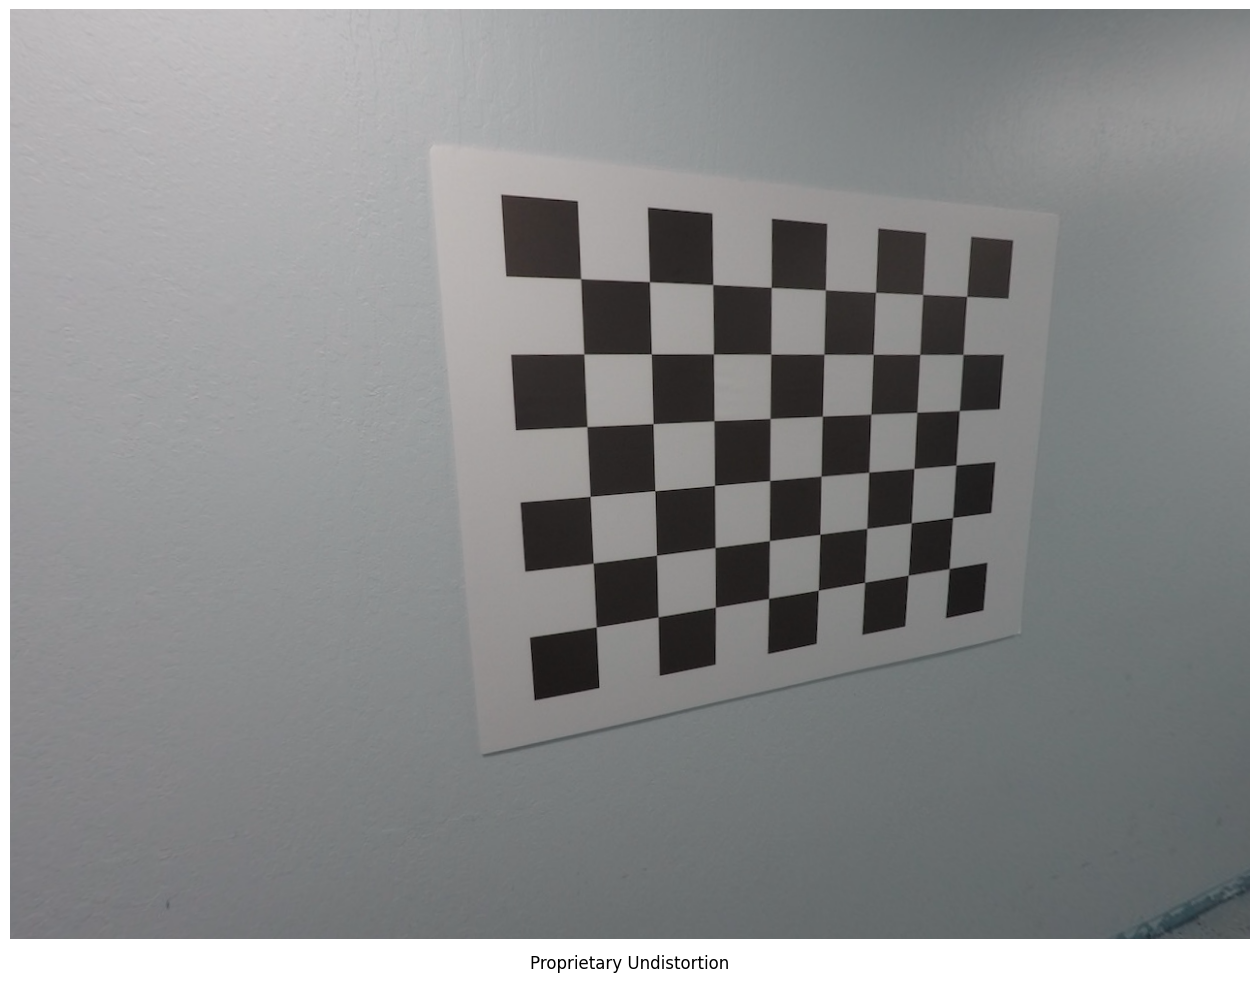

In [8]:
dist_vec = np.array([ 
                        [k0],
                        [k1],
                        [t0],
                        [t1],
                        [k2]
                    ])

small_scale = 1
new_mtx, roi = cv.getOptimalNewCameraMatrix(K, dist_vec, (w, h), 0.0, (w, h))
tmp_i = cv.undistort(img, K, dist, None, new_mtx)


dst_small = cv.resize(tmp_i, ( int(dst.shape[1]*small_scale), int(dst.shape[0]*small_scale)) )
show_img(tmp_i, 'Proprietary Undistortion')

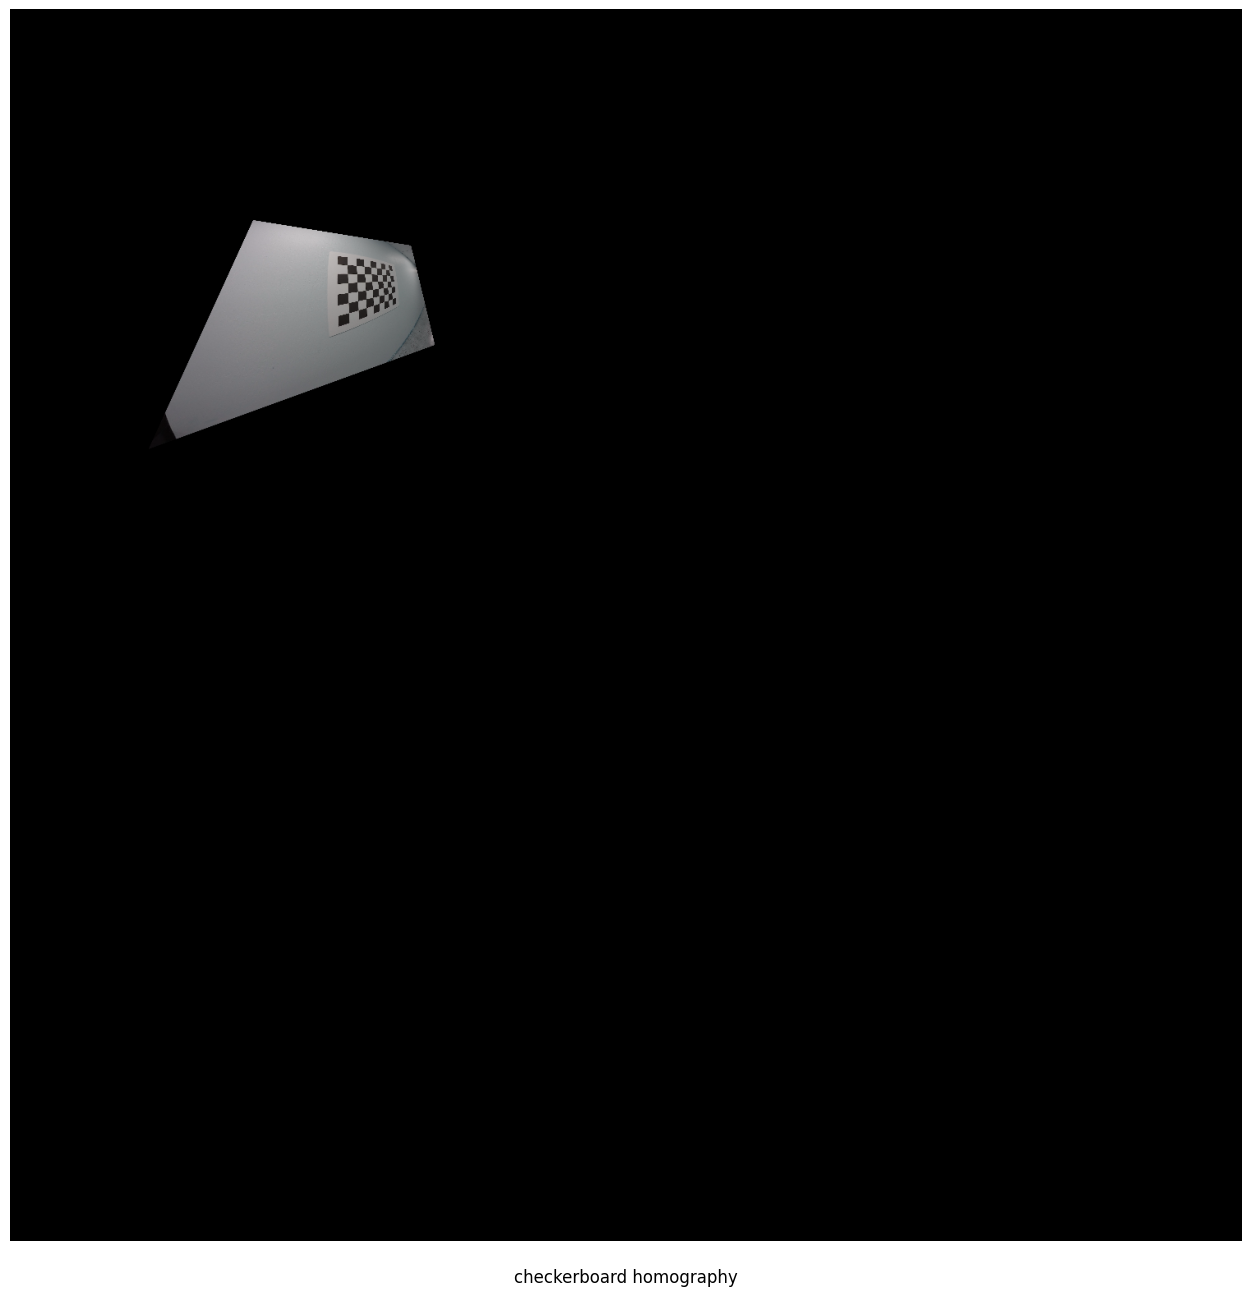

In [9]:
# _all_hs # Do something with this...?
# _all_hs_opt


# 8x6 has a spread of ???

the_homography = _all_hs_opt[10]
tmp = np.linalg.inv(the_homography)
scale_f  = 25
scale = np.array([
    [scale_f,  0.0,     300],
    [ 0.0,     scale_f, 300],
    [ 0.0,     0.0,     1.0]
])
tmp = scale @ tmp
new_img = cv.warpPerspective(img, tmp, (1500, 1500), flags=cv.INTER_LINEAR)
show_img(new_img, 'checkerboard homography')

In [10]:
print('Proprietary Camera_Intrinsics:\n', K)
print('Proprietary Camera_Distortion:\n', dist_vec)

Proprietary Camera_Intrinsics:
 [[559.49284623   0.61517522 649.72847644]
 [  0.         560.59464685 498.82733597]
 [  0.           0.           1.        ]]
Proprietary Camera_Distortion:
 [[-0.23237013]
 [ 0.06145965]
 [ 0.00006521]
 [ 0.00034648]
 [-0.00750106]]


In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib tk
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.colors
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


def _find_start_pos(obj_pts, K, rot, trans):

    inv_K = np.linalg.inv(K)


    world_0_0 = obj_pts[0]
    world_4_4 = obj_pts[36]

    trans = np.concatenate((rot, trans), axis=1)
    trans = np.concatenate((trans, np.array([0, 0, 0, 1])))

    
    tmp_0_0 = trans @ np.array([
                                    world_0_0[0],
                                    world_0_0[1],
                                    world_0_0[2],
                                    1.0
                                ])
    

    tmp_4_4 = trans @ np.array([
                                    world_4_4[0],
                                    world_4_4[1],
                                    world_4_4[2],
                                    1.0
                                ])

    line_0_0 = tmp_0_0 / tmp_0_0[-1][0]
    line_4_4 = tmp_4_4 / tmp_4_4[-1][0]

    # Find closest point between
    # 
    # TODO


    start_pos = np.zeros(3)
    return start_pos


def _draw_camera(ax, start_pos, rot, trans):

    origin = np.array([ 0.0, 0.0, 0.0, 1.0 ])
    bot_left = np.array([ -0.5, -0.5, 1, 1.0])
    top_left = np.array([ -0.5, 0.5, 1, 1.0])
    top_right = np.array([ 0.5, 0.5, 1, 1.0])
    bot_right = np.array([ 0.5, -0.5, 1, 1.0])

    pts = np.array([
        origin, bot_left, top_left,

        origin, top_left, top_right,

        origin, top_right, bot_right,

        origin, bot_right, bot_left
    ])


    # Scaling
    scale_f = 2.0
    scale_mat = np.array([
        [scale_f, 0, 0, 0],
        [0, scale_f, 0, 0],
        [0, 0, scale_f, 0],
        [0, 0, 0, 1]
    ])

    # Other transforms
    if rot is None:
        rot = np.identity(3)
    if trans is None:
        trans = np.zeros((3,1))

    tx = trans[0][0]
    ty = trans[1][0]
    tz = trans[2][0]
    trans_col = np.array([
                            [tx],
                            [ty],
                            [tz],
                        ])
    trans = np.concatenate( (rot, trans_col), axis=1 )
    trans = np.concatenate( ( trans, np.array([[0,0,0,1]]) ), axis=0)
    start_pos_trans = np.identity(4)
    start_pos_trans[0][3] = start_pos[0]
    start_pos_trans[1][3] = start_pos[1]
    start_pos_trans[2][3] = start_pos[2]
    trans = np.linalg.inv(trans)
    trans = trans @ start_pos_trans @ scale_mat

    pts = (trans @ pts.T).T


    triangles = []
    num_pts = len(pts)
    i = 0
    while i < num_pts:
        x0 = pts[i][0] / pts[i][3]
        y0 = pts[i][1] / pts[i][3]
        z0 = pts[i][2] / pts[i][3]
        i+=1

        x1 = pts[i][0] / pts[i][3]
        y1 = pts[i][1] / pts[i][3]
        z1 = pts[i][2] / pts[i][3]
        i+=1

        x2 = pts[i][0] / pts[i][3]
        y2 = pts[i][1] / pts[i][3]
        z2 = pts[i][2] / pts[i][3]
        i+=1

        triangles.append( ((x0, z0, y0), (x1, z1, y1), (x2, z2, y2)) )


    ax.add_collection(Poly3DCollection(triangles, alpha=0.5))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


x_size = 8 + 1
y_size = 6 + 1
x = np.arange(x_size)
y = np.arange(y_size)
X,Y = np.meshgrid(x, y)
Z = np.zeros_like(X)


broad_limits = 10
ax.set_xlim(-broad_limits, broad_limits+x_size)
ax.set_ylim(-broad_limits, broad_limits+y_size)
ax.set_zlim(-5, broad_limits)
ax.set_aspect('equal')

tmp = np.zeros( (y_size-1,x_size-1,4) )
for r in range(y_size-1):
    for c in range(x_size-1):
        if (r % 2 == 0 and c % 2 == 1) or (r % 2 == 1 and c % 2 == 0):
            tmp[r][c][0] = 1.0
            tmp[r][c][1] = 1.0
            tmp[r][c][2] = 1.0
        tmp[r][c][3] = 1.0

# Plot line in 3D
ax.plot_surface(X, Z, Y, facecolors=tmp, shade=False)


eleventh_obj_points = objpoints[10]
eleventh_rot = all_Rs[10]
eleventh_trans = all_Ts[10]
start_pos = np.zeros(3)
#start_pos = _find_start_pos(eleventh_obj_points, K, eleventh_rot, eleventh_trans)


start_pos[0] = 5.0
start_pos[1] = -2.5
start_pos[2] = -4.0
num_views = len(all_Rs)
for i in range(num_views):
    rot = all_Rs[i]
    trans = all_Ts[i]
    _draw_camera(ax, start_pos, rot, trans)



ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()